In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("../input/ames.csv")

首先，您需要选择要应用目标编码的功能。具有大量类别的分类特征通常是很好的候选项。运行此单元格以查看 Ames 数据集中每个分类特征有多少个类别。

In [2]:
df.select_dtypes(["object"]).nunique()
# 这段代码会输出一个表格，其中包含了所有的分类特征以及它们的唯一值数量。这个表格可以帮助你决定哪些特征是分类特征，以及哪些特征是有序的。
df.select_dtypes(["object"]).nunique().nlargest(5)

Neighborhood    28
Exterior2nd     17
MSSubClass      16
Exterior1st     16
OverallQual     10
dtype: int64

我们讨论了 M 估计编码如何使用平滑来改进稀有类别的估计。要查看某个类别在数据集中出现的次数，您可以使用 value_counts 方法。此单元格显示 SaleType 的计数，但你可能还需要考虑其他单元格。

In [3]:
df["SaleType"].value_counts()

SaleType
WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64

The Neighborhood feature looks promising. It has the most categories of any feature, and several categories are rare. Others that could be worth considering are SaleType, MSSubClass, Exterior1st, Exterior2nd. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.
邻域功能看起来很有前途。它拥有所有功能中最多的类别，并且有几个类别很少见。其他值得考虑的函数包括 SaleType、MSSubClass、Exterior1st、Exterior2nd。事实上，由于稀有类别的普遍存在，几乎所有名义特征都值得尝试。

In [4]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

# 2) Apply M-Estimate Encoding

Apply a target encoding to your choice of categorical features. Also choose a value for the smoothing parameter `m` (any value is okay for a correct answer).

In [5]:
# YOUR CODE HERE: Create the MEstimateEncoder
# Choose a set of features to encode and a value for m
encoder = MEstimateEncoder(cols=["Neighborhood"], m=5.0)


# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)


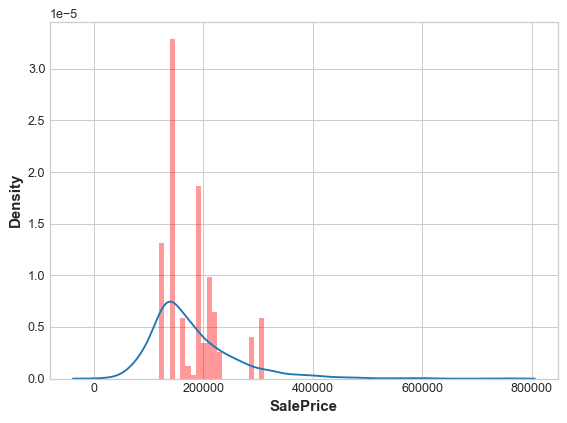

In [6]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");
# density 是密度，hist 是直方图，kde 是核密度估计
# norm_hist=True 表示直方图的面积为1
# kde=False 表示不显示核密度估计
# hist=False 表示不显示直方图
# 下图是转换后的salesprice的分布图，这就是目标编码后的结果


In [7]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1434 RMSLE
Score with Encoding: 0.1398 RMSLE


In [8]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 0

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0375 RMSLE


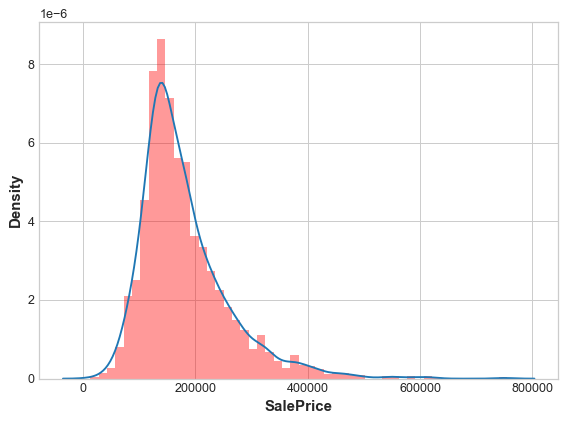

In [9]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");